# Exploratory Analysis of NCS Catalog & Transaction Data

### Table of Contents
1. [Are We Charging the Right Amount?](#What-is-the-distribution-of-prices,-and-how-many-things-cost-the-same?)
2. [How Much Money Are We Not Making?](#How-much-money-are-we-not-making?)
3. [What Does "Department" Mean?](#Are-some-departments-more-expensive-than-others?)
4. [Are Gluten-Free and Organic Products More Expensive?](#Are-gluten-free-or-organic-products-more-expensive?)
5. [Is it Worth Selling Gluten-Free and Organic Products?](#Which-departments-carry-the-most-organic-products?-Which-ones-sell?)
6. [What Are the Popular Products?](#What-are-the-most-popular-elements-of-products?)
7. [Why Do Spending Customers Keep Coming Back?](#Who-are-you-best-and-worst-customers?-Why?)
8. [If a Customer Buys Avocado, What Else Will They Buy?](#)
8. [Summary](#Summary)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

Read in the data file and view the first few rows.

In [2]:
df = pd.read_csv('Data/catalog.csv', engine="python")
tdf = pd.read_csv('Data/10000_transactions.csv', engine="python")

df.head()

,prod_id,prod_name,department_id,price
0,36235,Organic Pure Extra Virgin Coconut Oil,13,12.02
1,24879,Pepperidge Farm® Goldfish Queso Fiesta Baked S...,19,4.17
2,37062,Pineapple Coconut Water Enhancer,7,8.77
3,7770,Quick-Tie Tall Kitchen Bags Gallon - 35 CT,17,3.56
4,14435,Bowl Blaster Toilet Bowl Cleaner,17,5.59


In [3]:
tdf.head()

,order_number,product_id,customer_id,product_name,department_id,price
0,2,33120,202279,Organic Egg Whites,16,5.33
1,5,48370,156122,Sensitive Toilet Paper,17,9.33
2,7,46802,142903,Pineapple Chunks,1,6.76
3,10,3464,135442,"Organic Butterhead (Boston, Butter, Bibb) Lettuce",4,9.00
4,10,25720,135442,Organic Sunchoke,4,10.06


## What is the distribution of prices, and how many things cost the same?
Let's assess which price amounts are used, and let's look at how many products are costed at each pricing amount.

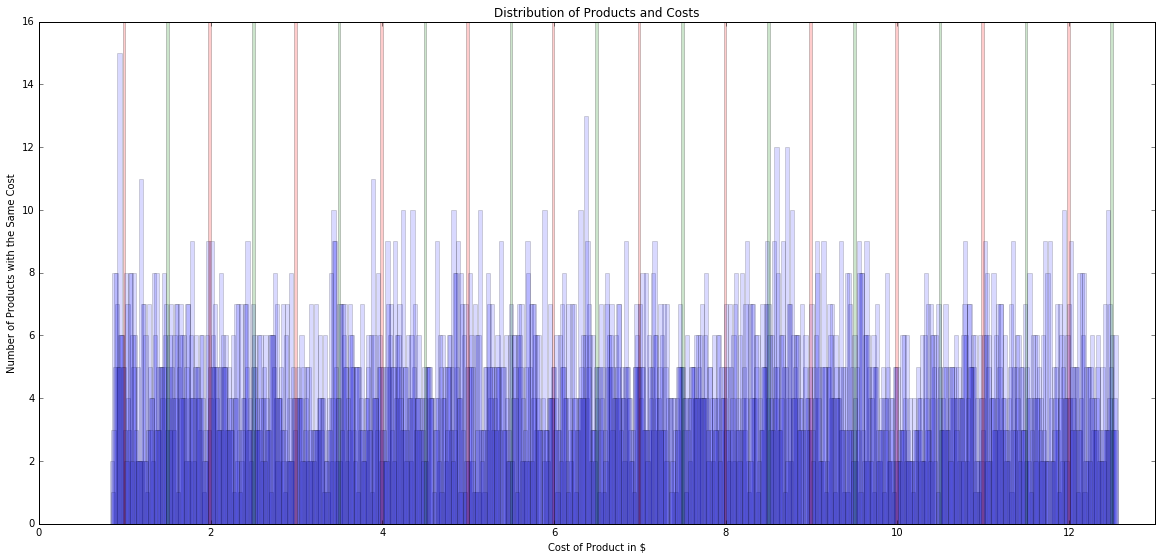

In [4]:
newPrice = []
for price in df['price']:
    newPrice.append(round(price, 2))

counted = Counter(newPrice)
index = np.arange(len(counted.keys()))
plt.figure(figsize=(20,9))

nns = []
for i in range(0, 12):
    nns.append(0.99 + 1*i)
fns = []
for i in range(1, 13):
    fns.append(0.497 + 1*i)
height = []
for i in range(12):
    height.append(16)
plt.bar(counted.keys(), counted.values(), align='center', color='b', width=0.05, alpha=0.15)
plt.bar(nns, height, color='r', align='center', width=0.03, alpha=0.2)
plt.bar(fns, height, color='g', align='center', width=0.03, alpha=0.2)

plt.axis([0, 13, 0, 16])
plt.xlabel('Cost of Product in $')
plt.ylabel('Number of Products with the Same Cost')
plt.title('Distribution of Products and Costs')
plt.show()

Green lines mark the \$\_.00 pints along the cost axis. Red lines mark the \$\_.99 points. Notably, only the \$1.99 price tag has more products priced at 99 cents than at the adjacent 98 cents or rounded dollar amounts. This could suggest that **more profits could be made**, if [psychological pricing](https://en.wikipedia.org/wiki/Psychological_pricing) is used to motivate pricing models.
No items are priced higher than \$12.55, meaning that this data source is possibly pulled from a distributor which does not sell bulk products, as these tend to be more expensive. 

While we're at it, let's see which items are being priced on the far left or far right of the range of prices, as well as the tall spike behind the first red line.

In [5]:
minPrice = min(newPrice)
minItems = df[df['price'] == minPrice][['department_id', 'prod_name']]
print("Cheapest Items, at $%.2f:" % minPrice)
for index, item in minItems.iterrows():
    print("%i - %s" % (item['department_id'], item['prod_name']))

maxPrice = max(newPrice)
maxItems = df[df['price'] == maxPrice][['department_id', 'prod_name']]
print("\nMost Expensive Items, at $%.2f:" % maxPrice)
for index, item in maxItems.iterrows():
    print("%i - %s" % (item['department_id'], item['prod_name']))

maxCount = max(counted, key=counted.get)
countItems = df[df['price'] == maxCount][['department_id', 'prod_name']]
print("\nItems Most Sharing the Same Cost, at $%.2f" % maxCount)
for index, item in countItems.iterrows():
    print("%i - %s" % (item['department_id'], item['prod_name']))

Cheapest Items, at $0.85:
7 - Chocolate Pu Erh Tea 16 ct
11 - Body Wash Pink Grapefruit Body Clear®

Most Expensive Items, at $12.55:
1 - Old Fashioned Vanilla Frozen Custard
16 - Original Strawberry Low Fat Yogurt
1 - Cheese Pizza In A Pocket Sandwich

Items Most Sharing the Same Cost, at $0.94
13 - Organic Ground Coriander
4 - Organic Pomegranate
19 - Mini Vanilla Chewy Chocolate Nougats
2 - Immunity Health, Gummy Bears
6 - Plum Sauce
19 - Bunny Ears Crisp Wafers in Milk Chocolate
19 - Dried Cherry Montmorency Tart
1 - All Natural Premium Cornish Hen
16 - Original Whipped Cream
7 - Organic Lemonade Cherry
1 - Pizzeria! Thin Margherita Pizza
3 - Gluten Free Blueberry Muffins
11 - Allergy Plus Congestion Grape Flavored Liquid
11 - Congestion Non-Drowsy Maximum Strength Phenylephrin HCl Tablets
4 - Butter Babies Potatoes


The number prefixing each item is the department where that product comes from. We can see that the most expensive products share a common trait: they are **dairy products**. 

These numbers raise a new question...

## How much money are we not making?
More items are priced at \$0.94 than any other. How many of these products are being sold? How much money could be saved if we sold these items for \$0.99 instead?

In [6]:
product094 = df[df['price'] == 0.94]
sold094 = len(product094)
actualRevenue=sold094*0.94

suggestedPrice=0.99
suggestedRevenue=0.99 * sold094
revenueDelta=suggestedRevenue-actualRevenue

print("Number of products sold at $0.94: \n%i" % sold094)
print("Profit if sold at $0.99: \n$%.2f" % revenueDelta)

Number of products sold at $0.94: 
15
Profit if sold at $0.99: 
$0.75


What if we rounded every price up to the nearest nine-cent value? For example, \$3.11 becomes \$3.19. How would the table of Distribution of Price and Costs change, and how much more money would be made?

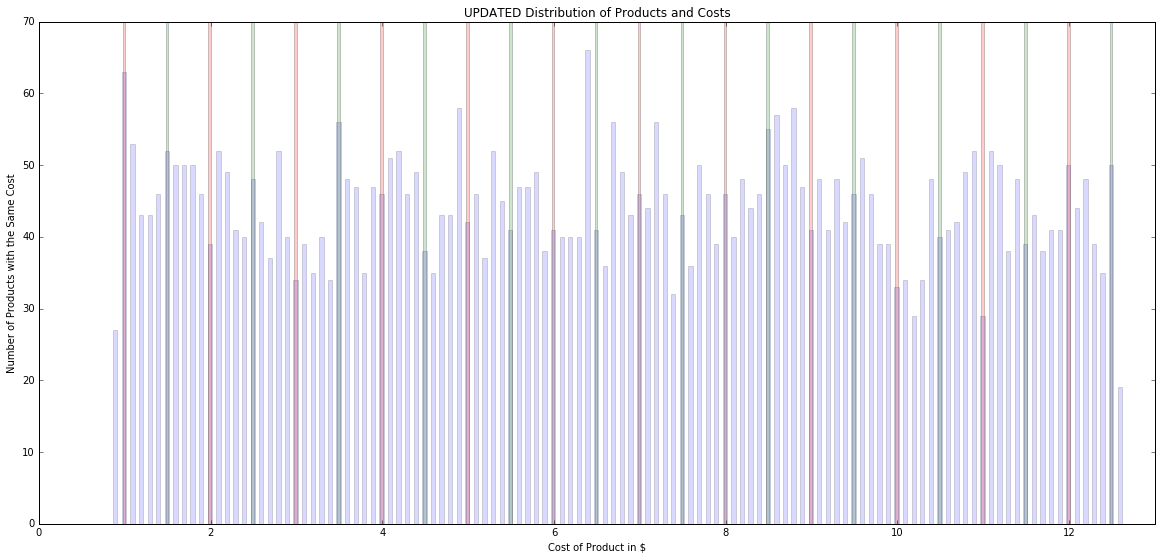

Amount of money made by rounding up to nearest 9 cents: $183.98
Amount of money made by selling every item once with current pricing model: $34504.31
Percentage profit gain by using 9-cent rounded model: 0.533%


In [7]:
def roundx(x):
    decimal = x - round(x,1)
    if decimal > 0:
        floor = round(x, 1)
        floor = floor + 0.09
        return floor
    else:
        ceil = round(x, 1)
        ceil = ceil - 0.01
        return ceil

updatedPrices = df.apply(lambda x: roundx(x['price']), axis=1).tolist()
newPrice = []
for price in updatedPrices:
    newPrice.append(round(price, 2))
counted=Counter(newPrice)
index = np.arange(len(counted.keys()))
plt.figure(figsize=(20,9))

nns = []
for i in range(0, 12):
    nns.append(0.99 + 1*i)
fns = []
for i in range(1, 13):
    fns.append(0.49 + 1*i)
height = []
for i in range(12):
    height.append(70)
plt.bar(counted.keys(), counted.values(), align='center', color='b', width=0.05, alpha=0.15)
plt.bar(nns, height, color='r', align='center', width=0.03, alpha=0.2)
plt.bar(fns, height, color='g', align='center', width=0.03, alpha=0.2)

plt.axis([0, 13, 0, 70])
plt.xlabel('Cost of Product in $')
plt.ylabel('Number of Products with the Same Cost')
plt.title('UPDATED Distribution of Products and Costs')
plt.show()

newRevenue = 0
currentModelRevenue = 0
i = 0
for base in df['price']:
    newRevenue = newRevenue + (updatedPrices[i] - base)
    currentModelRevenue = currentModelRevenue + base
    i = i + 1
print "Amount of money made by rounding up to nearest 9 cents: $%.2f" % newRevenue
print "Amount of money made by selling every item once with current pricing model: $%.2f" % currentModelRevenue
print "Percentage profit gain by using 9-cent rounded model: %.3f%%" % (newRevenue / currentModelRevenue * 100)

Even after rounding everything up to the nearest 9 cents, there is a surprising lack of emphasis along the red lines which mark 99 cents. The green lines marking 45 cents spike a bit heavier but are not huge either. Rounding prices to the left of these lines to be priced at these lines **might possibly increase revenue without decreasing sales.**

The \$184 value is the total amount of money involved in difference between the current pricing model and this 9-cent rounded model. In other words, if every product was sold once with this rounded model, an additional profit of \$184 would be made compared to selling every product once with the current model. This is a 0.533% increase in profits.

## Are some departments more expensive than others?
From the previous section, we notice that two of the three most expensive items come from Department 1. Could it be that Department 1 sells particularly expensive items compared to the other departments?

Average cost of all items: $6.62


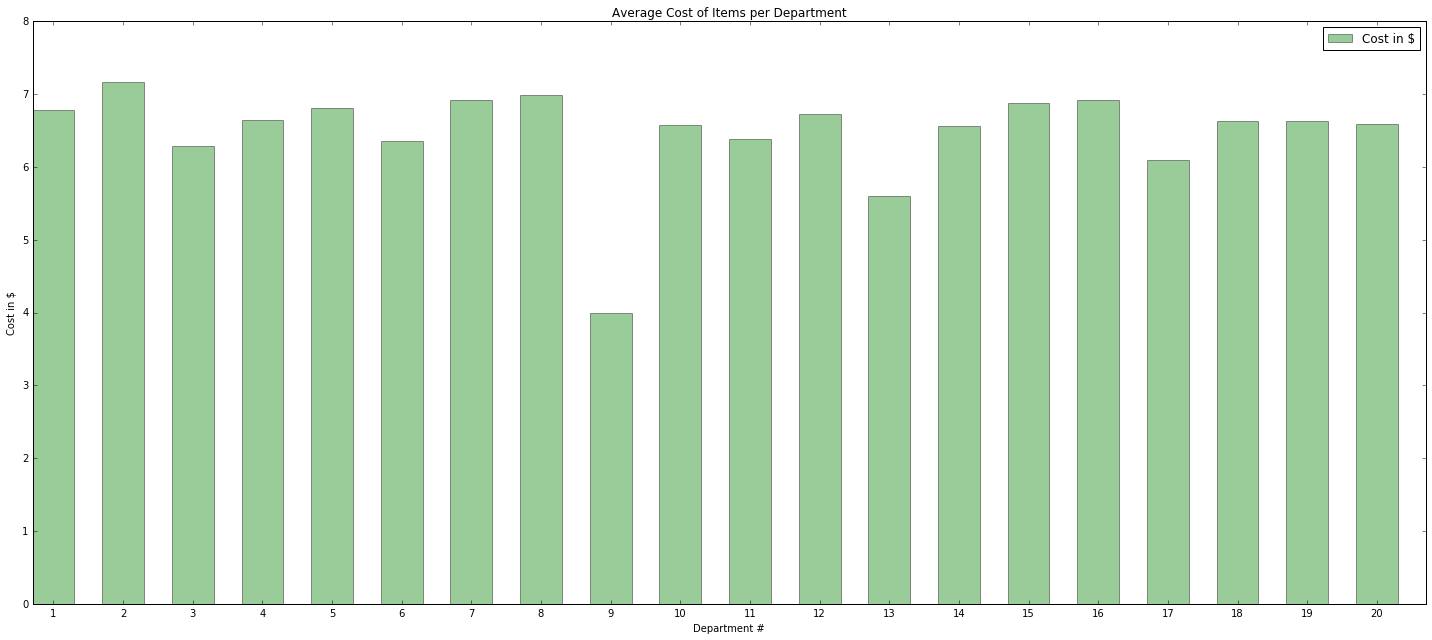

In [8]:
avgCost = df['price'].mean()
print("Average cost of all items: $%.2f" % avgCost)

costByID = df.groupby(['department_id', 'price']).sum().reset_index().groupby('department_id').mean()

groups = 21
plt.figure(figsize=(20,9))

index = np.arange(groups)
bar_width = 0.6

opacity = 0.4

rects = plt.bar(index, costByID['price'], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Cost in $')

plt.xlabel('Department #')
plt.ylabel('Cost in $')
plt.title('Average Cost of Items per Department')

plt.xticks(index + bar_width / 2, range(0, 22))

plt.axis([1, 21, 0, 8])
plt.legend()
plt.tight_layout()
plt.show()

**Department 9** is particularly cheaper than others. This suggests that Department 9 contains items often sold cheaply, such as candy. It would be wise to define what is sold in this Department and that items from this department are expected to be cheap; if not, this could be an opportunity to raise prices for these products.

It turns out that Department 1 is not the most expensive item. Instead, **Department 3** is a bit more expensive than the rest. This suggests that Department 3 contains more premium products such as gluten free or organic offerings. Alternatively, the most generally expensive products are in this department, such as meat.

By looking at the product catalog, we might be able to identify departments based on their products.

## Are gluten free or organic products more expensive?
We've seen that some products are listed as "Gluten Free", "GF", or "Organic". Our observations about the expensive Department 3 make us hypothesize that many of these health-sensitive products are contained in this department. Overall, we can look at products labeled with the above words, and see if they are more expensive than other products.

592 organic/GF products
4629 other products
12.8% of products are organic/GF


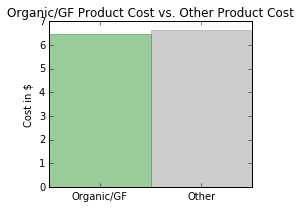

Organic is cheaper than global average by 2.1%.


In [9]:
# Get target, a DF of all organic and gluten free products
df['prod_name'] = df['prod_name'].str.lower()
organic = df[df['prod_name'].str.contains("organic")]
glutenFree = df[df['prod_name'].str.contains("gluten free")]
gF = df[df['prod_name'].str.contains("gf")]
frames = [organic, glutenFree, gF]
target = pd.concat(frames)

# Get others, a DF of all products which are not in target
ds1 = set([ tuple(line) for line in target.values.tolist()])
ds2 = set([ tuple(line) for line in df.values.tolist()])
others = pd.DataFrame(list(ds2.difference(ds1)))
others.columns = target.columns.tolist()

print("%i organic/GF products\n%i other products" % (len(target), len(others)))
percentHealth = len(target)*1.0/len(others)*100
print("%.1f%% of products are organic/GF" % percentHealth)

# Get average of all target products, and of all others products.
healthAvg = target['price'].mean()
otherAvg = others['price'].mean()

avgList = [healthAvg, otherAvg]

groups = 2

index = np.arange(groups)
bar_width = 1

opacity = 0.4
plt.figure(figsize=(4,3))

rects = plt.bar(index, avgList, bar_width, align='center', alpha=opacity)
rects[0].set_color('g')
rects[1].set_color('grey')

plt.ylabel('Cost in $')
plt.title('Organic/GF Product Cost vs. Other Product Cost')
labels = ["Organic/GF", "Other"]
plt.xticks(index, labels)

plt.tight_layout()
plt.show()

organicPercentage = (1 - healthAvg*1.0 / avgCost) * 100
print("Organic is cheaper than global average by %.1f%%." % organicPercentage)

Turns out, eater-sensitive products are cheaper than the average non-sensitive product, and cheaper than the global average by 2.1%! This could be a great **advertising point**, to encourage customers to make healthy choices!

## Which departments carry the most organic products? Which ones sell?
We don't want to carry products that don't sell well. We can combine transaction and catalog data to find how many organic products are offered and sold in each department.

## What are the most popular elements of products?
There is lots of transaction data which records what customers buy. Of all the things they buy, which words describe the most popular products?

In [10]:
commonWords = Counter(" ".join(tdf["product_name"]).split()).most_common(100)
def generateWordCloudString(tuples):
    wcString = ""
    for t in tuples:
        t_lower = t[0].lower()
        for count in range(t[1]/10):
            wcString = " " + t_lower + wcString
    return wcString

wcWords = generateWordCloudString(commonWords)
# exportWCText(wcWords)

def exportWCText(wcString):
    with open("Output.txt", "w") as text_file:
        text_file.write("{0}".format(wcWords))
#     Word cloud generated with: https://www.jasondavies.com/wordcloud/



We can see that organic products are highly valued by customers who shop here. Any of the following could be at play as a cause or an effect of this observation:
- As previously observed, organic products are cheap here.
- There is a large selection of produce.
- The store's brand is one well-known for healthy products.

## Who are the best customers? Why do they keep coming back?
Transaction data also keeps track of who buys what. Is there anything in common with what the most frequent shoppers buy that might keep them coming back? Or might there be anything we could learn from those customers that have only shopped once?

In [11]:
commonCust = Counter(tdf["customer_id"]).most_common(100)
for i in range(10):
    print commonCust[i][0]

6409
60694
100330
5360
127427
168651
87634
127525
34200
199862


Each customer is assigned an id number unique to them. When they make a purchase, their activity is logged along with their id. We can use this id to analyze these frequent shopper's purchases. 

In [12]:
productPool = []
for custID in commonCust:
    custProductsDF = tdf[tdf['customer_id'] == custID[0]]
    custProducts = custProductsDF['product_name'].tolist()
    productPool.extend(custProducts)

commonProduct = Counter(" ".join(productPool).split()).most_common(100)
    
wcProdWords = generateWordCloudString(commonProduct)
# exportWCText(wcProdWords)



These look very similar to the most popular products overall. Are there any words or products that regular customers purchase that are not in the pool of most popular products?

In [13]:
allWords = wcWords.split()
popWords = wcProdWords.split()

def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

popOnly = diff(popWords, allWords)
for word in popOnly:
    print word

spread
blended
cinnamon
2
skim
spinach,
ginger
hazelnut
pear


Some of these words seem to be incomplete names of products. Let's see which products these words are actually referring to.

In [14]:
spread = set([s for s in productPool if "Spread" in s])
blended = set([s for s in productPool if "Blended" in s])
two = set([s for s in productPool if " 2 " in s])
skim = set([s for s in productPool if "Skim" in s])
spinach = set([s for s in productPool if "Spinach," in s])

foodLists = [spread, blended, two, skim, spinach]
specificFoods = []
for l in foodLists:
    for item in l:
        print item

Light Vegetable Oil Spread
Hazelnut Spread With Skim Milk & Cocoa
Soy Free Buttery Spread
Cream Cheese Cream Cheese Spread
Organic Blended Raspberry Whole Milk Greek Yogurt
Organic Greek Whole Milk Blended Strawberry Yogurt
Greek Whole Milk Blended Blueberry Yogurt
Peach Mango Stage 2 Baby Food
Baby Food Stage 2 Blueberry Pear & Purple Carrot
Organic Stage 2 Winter Squash Baby Food Puree
Skim Milk
Hazelnut Spread With Skim Milk & Cocoa
Mozzarella Light Low Moisture Part Skim String Cheese
Little Yums Spinach, Apple, and Kale Teething Wafers
Super Foods/Organic Apples, Spinach, Peas & Broccoli + Super Chia Snack Pouch
Super Spinach! Baby Spinach, Baby Bok Choy, Sweet Baby Kale


Looking through this list reveals at least the following observations:
- Baby Food in many of its various forms are valued products. The data suggests that **parents are concerned about their little ones eating well early in life.** This detail might motivate promotional events, sales, or advertising for baby food products.
- "Hazelnut Spread With Skim Milk & Cocoa" is a valued product, as it represents two popular products, namely Hazelnut and Spread, in one.
- Blended Yogurt is a valued product.
These seem to be more specialty items compared to general products like chicken or milk, but something about the price or quality of these items **keep customers coming back**. 

Distributors should consider making sure these products stay available. These products are prime targets for putting on sale to draw in new regular customers and improve customer satisfaction.

## What do customers buy together?
Customers often buy multiple products at once. Sometimes, they buy products because those items go together. For example, if a customer buys lunch meat, we could reasonably expect them to purchase bread, mustard, or lettuce on the same visit. If we know what items customers buy together, we can organize marketing, store layouts, and more to increase sales and improve the customer experience.

# Summary
- Graphs of pricing show a lack of psychological pricing. Distributor might consider rounding prices up (or down in some cases) in order to maximize profits and increase sales.
- The most expensive products on sale are dairy products.
- Many products from Department 3 are priced around \$4. Distributor might ensure that this is correct and that potential profits are not being lost from products in this department.
- On average, organic and gluten free products are 2% cheaper than the average product. Distributor might consider using this as point in advertising.
- Products such as spinach, ginger, and pear are purchased more frequently by returning customers than by the average customer. Distributor might consider ensuring the availability of these products, making them easily accessible, or providing promotions.